In [ ]:
# we need the following libraries, so let's install them
!pip install boto3
!pip install torchxrayvision
!pip install SimpleITK
!pip install radiomics
!pip install pyradiomics
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'/content/sample_data/NIH-ChestXray-14/filters'

In [ ]:
# check for the avaialblity of GPUs
!nvidia-smi
import torch
torch.cuda.is_available()

Wed May 24 22:26:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
# importing libraries
from time import time
import numpy as np
import pandas as pd
from glob import glob
import os
import SimpleITK as sitk
import skimage, torchvision
import torchxrayvision as xrv
import torchvision
import torchxrayvision as xrv
import matplotlib.pyplot as plt
from tqdm import tqdm
# importing written classes and methods
import sys
from radiomics import featureextractor
from radiomics import firstorder, glcm, glrlm, glszm, shape, shape2D, ngtdm, gldm
import warnings
import logging

warnings.filterwarnings("ignore", category=DeprecationWarning)

# set level for all classes
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)
# ... or set level for specific class
logger = logging.getLogger("radiomics.glcm")
logger.setLevel(logging.ERROR)

In [ ]:
# making new directories to save new files
directory_ = '/content/sample_data/NIH-ChestXray-14/'
directory_processed_images = directory_ + 'processed_images'
directory_filterss = directory_ + 'filters'
directory_segments = directory_ + 'segments'
directory_cleaned_targets = directory_ + 'cleaned_targets'
# no need to run
try:
  os.makedirs(directory_processed_images)
except:
  pass

try:
  os.makedirs(directory_filterss)
except:
  pass

# try:
#   os.makedirs(directory_segments)
# except:
#   pass

# try:
#   os.makedirs(directory_cleaned_targets)
# except:
#   pass

In [ ]:
# the main class used to segment and extract segmentation filters
class ChestXRaySegmentation:
    def __init__(self, image_size: int = 512, threshold: float = 0.5):
        """

        :param image_size:
        :param threshold:
        """
        self.image_size = image_size
        self.threshold = threshold
        self.resizer = torchvision.transforms.Compose([xrv.datasets.XRayResizer(self.image_size)])
        self.centerer = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop()])

        def device_selector_cuda(image:np.ndarray):
          return torch.from_numpy(image).cuda(device="cuda:0")

        def device_selector_cpu(image:np.ndarray):
          return torch.from_numpy(image).cpu()

        #----------------------------------------------------------------
        print(f'device is {torch.cuda.is_available()}')
        if torch.cuda.is_available():
          dvc = "cuda:0"
          self.model_segment = xrv.baseline_models.chestx_det.PSPNet().cuda(device=dvc)
          self.device_selector = device_selector_cuda
        else:
          self.model_segment = xrv.baseline_models.chestx_det.PSPNet()
          self.device_selector = device_selector_cpu
        #----------------------------------------------------------------

        self.normalizer = xrv.datasets.normalize
        self.loader = skimage.io.imread
        self.composer = torchvision.transforms.Compose
        self.segment_names = self.model_segment.targets
        self.num_segments = len(self.segment_names)
        self.image = np.zeros(shape=(1, self.image_size, self.image_size))
        self.segment_index = [4,5,8,13]
        #self.segment_index = list(range(14))
    def prep(self, name: str):
        self.image = self.resizer(self.centerer(self.normalizer(self.loader(name)[:,:,0], 255)[np.newaxis, :, :]))
        return self.device_selector(self.image)


    def prep_segment(self, name: str):
        with torch.no_grad(): return self.model_segment(self.prep(name=name))[:,self.segment_index,:,:]

    def get_filters(self, name: str):
        probs = 1 / (1 + torch.exp(-self.prep_segment(name=name)))  # sigmoid function
        return torch.where(probs > self.threshold, 1.0, 0.0).cpu().numpy()

    def get_filter_image(self, name: str):
        probs = 1 / (1 + torch.exp(-self.prep_segment(name=name)))  # sigmoid function
        return torch.where(probs > self.threshold, 1.0, 0.0).cpu().numpy(), self.image, probs.cpu().numpy()

In [ ]:
# loading image labels
data_path = '/content/sample_data/NIH-ChestXray-14/targets/four_findings_expert_labels/individual_readers.csv'
data = pd.read_csv(data_path)
print(data.shape)
data.head(3)

(13081, 8)


,Patient ID,Image ID,Reader ID,Fracture,Pneumothorax,Airspace opacity,Nodule/mass,Set ID
0,13,00000013_008.png,4295367682,NO,YES,YES,NO,test
1,13,00000013_008.png,4295232296,NO,NO,YES,NO,test
2,13,00000013_008.png,4323195249,NO,NO,YES,NO,test


In [ ]:
# loading the location of objects
data_path = '/content/sample_data/NIH-ChestXray-14/images/NIH-CXR-14-small/BBox_List_2017.csv'
data = pd.read_csv(data_path)
print(data.shape)
data.head(1)

(984, 9)


,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN


In [ ]:
#  loading multiclass labels of each image 
data_path = '/content/sample_data/NIH-ChestXray-14/images/NIH-CXR-14-small/metadata.csv'
data = pd.read_csv(data_path)
print(data.shape)
data.head(3)

(112120, 20)


,Image Index,Patient ID,Patient Age,Patient Gender,View Position,No Finding,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,1,58,M,PA,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,58,M,PA,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,00000001_002.png,1,58,M,PA,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
# all view positions
pd.unique(data['View Position'])

array(['PA', 'AP'], dtype=object)

In [ ]:
# loading the labels of each image and filtering out non-frontal images
meta_data_target = pd.read_csv('/content/sample_data/NIH-ChestXray-14/images/NIH-CXR-14-small/metadata.csv')
meta_data_target.head(2)
N_all_samples = meta_data_target.shape[0]
print(f'total samples are: {N_all_samples}')
mask_lateral_samples = (meta_data_target['View Position']=='PA') | (meta_data_target['View Position']=='AP')
n_images = mask_lateral_samples.sum()
print(f'front image samples are: {n_images}')
truncated_target_data = meta_data_target[mask_lateral_samples]
truncated_target_data.reset_index(inplace=True)
truncated_target_data.head(2)

total samples are: 112120
front image samples are: 112120


,index,Image Index,Patient ID,Patient Age,Patient Gender,View Position,No Finding,Atelectasis,Cardiomegaly,Consolidation,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,00000001_000.png,1,58,M,PA,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,00000001_001.png,1,58,M,PA,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
# printing all variables in the label dataset
all_columns = list(truncated_target_data)
print(all_columns)

['index', 'Image Index', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'No Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [ ]:
# here we build a disctionary of all column variables  and save their values. finally all column variables are saved into a npy file
targets ={}
for col in all_columns:
  targets.update({col:truncated_target_data[col].values})

In [ ]:
# saving all labels into a dictionary
np.save(directory_cleaned_targets + '/new_targets.npy',targets)

In [ ]:
# we segment all images and save the processed image and its 4 segments
segmenter = ChestXRaySegmentation(image_size=512,threshold=0.5)
base_path = '/content/sample_data/NIH-ChestXray-14/images/NIH-CXR-14-small/images/'
n_error =0
for  n in tqdm(range(n_images)):
  try:
    location = truncated_target_data['Image Index'][n]
    picture_name = location.split('.')[0]
    filters,image,segments = segmenter.get_filter_image(base_path+picture_name + '.jpg')

    np.save(directory_filterss + '/' +picture_name+'__filters.npy',filters)
    np.save(directory_processed_images + '/' +picture_name+'__image.npy',image)
  except:
    n_error += 1
  #,  np.save(directory_segments + '/' +picture_name+'__segments.npy',segments)



device is True


100%|██████████| 112120/112120 [5:46:14<00:00,  5.40it/s]


In [ ]:
truncated_target_data['Image Index'][0]

'00000001_000.png'

In [ ]:
picture_name = location.split('/')[-1].split('.')[0]

'02aa804e-bde0afdd-112c0b34-7bc16630-4e384014'

In [ ]:
path = os.getcwd()
all_files = glob(path+'/*.png')

In [ ]:
mna = ChestXRaySegmentation(image_size=512,threshold=0.5)
filt,img,seg = mna.get_filter_image('/content/sample_data/NIH-ChestXray-14/images/NIH-CXR-14-small/images/00000001_000.jpg')

device is True


Text(0.5, 1.0, 'A sample of NIH image')

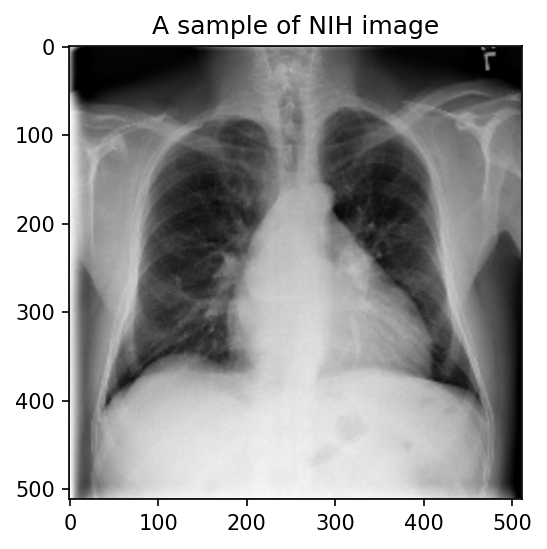

In [ ]:
# visualizing a  random image
plt.figure(dpi=150)
plt.imshow(img[0,:,:],cmap='gray')
plt.title('A sample of NIH image')

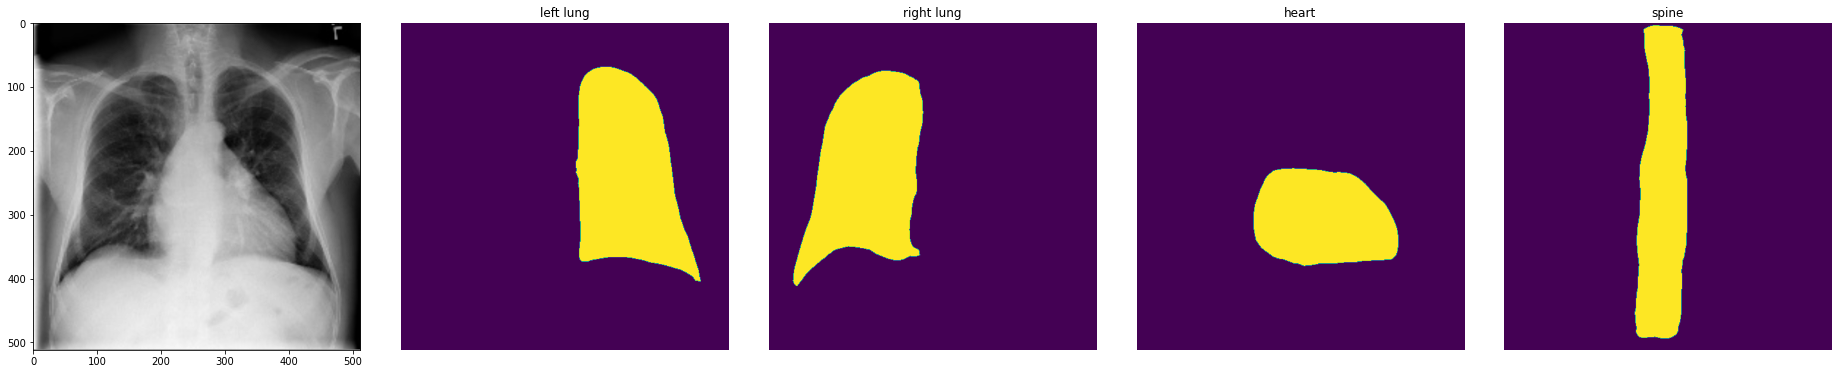

In [ ]:
# plotting all filters + processed image
plt.figure(figsize=(26, 5)) # the size of figures
plt.subplot(1, 4 + 1, 1) # 1+ 4 subplots
plt.imshow(img[0,:,:], cmap='gray')
nms = ['left lung','right lung','heart','spine']
for i in range(4):
    plt.subplot(1, 4 + 1, i + 2)
    plt.imshow(filt[0, i,:,:])
    plt.title(nms[i])
    plt.axis('off')
plt.tight_layout() # to force subplots fit in the figure

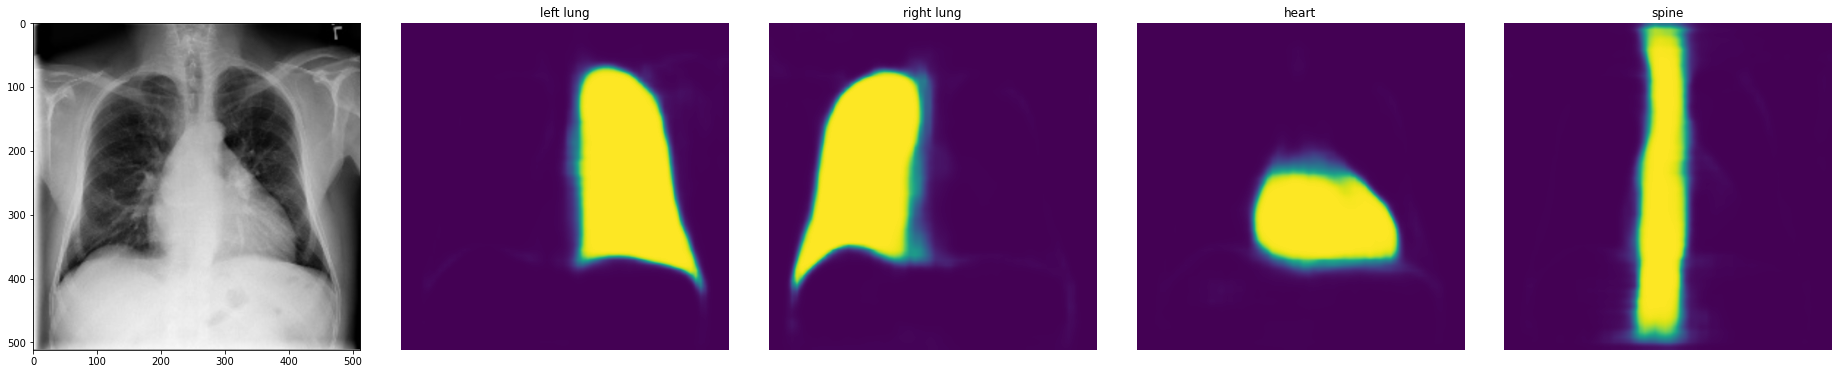

In [ ]:
# plotting all filters + processed image
plt.figure(figsize=(26, 5)) # the size of figures
plt.subplot(1, 4 + 1, 1) # 1+ 14 subplots
plt.imshow(img[0,:,:], cmap='gray')
nms = ['left lung','right lung','heart','spine']
for i in range(4):
    plt.subplot(1, 4 + 1, i + 2)
    plt.imshow(seg[0, i,:,:])
    plt.title(nms[i])
    plt.axis('off')
plt.tight_layout()